In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
import json
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import sys
import os


# Interactive widgets
from ipywidgets import widgets

In [10]:


# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(parent_dir)

# Now you can import the module
from src.utils.ml_utils import create_model

In [11]:
# Constants
IMG_SIZE = (224, 224)  # Image size (height, width)
BATCH_SIZE = 32  # Batch size

BASE_DIR = os.path.join(parent_dir, "artifacts", "processed")
# Example Usage
train_dir = os.path.join(BASE_DIR, "train")
val_dir = os.path.join(BASE_DIR, "val")
test_dir = os.path.join(BASE_DIR, "test")

In [12]:
def parse_jsonl(jsonl_path):
    """
    Parse a JSONL file and yield image paths and labels.
    """
    with open(jsonl_path, "r") as f:
        for line in f:
            item = json.loads(line)
            yield item["image"], item["label"]


def load_datasets_from_directory(data_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
    """
    Create a combined tf.data.Dataset from JSONL files in a directory.
    Args:
        data_dir (str): Directory containing JSONL files for train, val, or test splits.
        batch_size (int): Batch size for the dataset.
        img_size (tuple): Target size for images (height, width).
    Returns:
        tf.data.Dataset: Combined TensorFlow dataset.
    """
    # Collect all JSONL files in the directory
    jsonl_files = [
        os.path.join(data_dir, fname)
        for fname in os.listdir(data_dir)
        if fname.endswith(".jsonl")
    ]

    # Helper function to load and parse one JSONL file
    def load_single_jsonl(jsonl_path):
        """
        Create a tf.data.Dataset from a single JSONL file.
        """

        def generator():
            # Parse JSONL into image paths and labels
            with open(jsonl_path, "r") as f:
                for line in f:
                    item = json.loads(line)
                    yield item["image"], item["label"]

        # Create a dataset for this JSONL file
        dataset = tf.data.Dataset.from_generator(
            generator, output_types=(tf.string, tf.int32), output_shapes=((), ())
        )
        return dataset

    # Combine all datasets using flat_map
    combined_dataset = None
    for jsonl_path in jsonl_files:
        single_dataset = load_single_jsonl(jsonl_path)
        combined_dataset = (
            single_dataset
            if combined_dataset is None
            else combined_dataset.concatenate(single_dataset)
        )

    # Preprocessing pipeline
    def preprocess(image_path, label):
        # Load and decode image
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
        except tf.errors.NotFoundError:
            print(f"File not found: {image_path.numpy().decode('utf-8')}")
            return None, None

        # Resize
        image = tf.image.resize(image, img_size)
        return image, label

    # Apply preprocessing, batching, and shuffling
    combined_dataset = (
        combined_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(buffer_size=1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return combined_dataset


train_dataset = load_datasets_from_directory(train_dir)
# Check the type
dataset_type = type(train_dataset)
print(
    f"train_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)

val_dataset = load_datasets_from_directory(val_dir)
# Check the type
dataset_type = type(val_dataset)
print(
    f"val_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)


test_dataset = load_datasets_from_directory(test_dir)

# Check the type
dataset_type = type(test_dataset)
print(
    f"test_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)

# Example: Inspect a batch
for images, labels in train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
train_dataset inherits from tf.data.Dataset: True
val_dataset inherits from tf.data.Dataset: True
test_dataset inherits from tf.data.Dataset: True
Batch of images shape: (32, 224, 224, 3)
Batch of labels: [1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0]


2025-01-26 04:36:18.080868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
def load_custom_image_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """
    Load a custom dataset of images organized by 'charts' and 'non_charts' subdirectories.

    Args:
        directory (str): Path to the directory containing images organized in subdirectories by label.
        img_size (tuple): Target size for images (height, width).
        batch_size (int): Number of images per batch.

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing images and their labels.
        class_names (list): List of class names inferred from subdirectory names.
    """
    # Load dataset with labels inferred from directory structure
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",  # Infer labels from subdirectory names
        label_mode="int",  # Return integer labels
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
    )

    # Extract class names before transformations
    class_names = dataset.class_names

    return dataset, class_names


# Use it
custom_train_dir = "../data/processed/train"
custom_train_dataset, class_names = load_custom_image_dataset(custom_train_dir)

custom_val_dir = "../data/processed/val"
custom_val_dataset, _ = load_custom_image_dataset(custom_val_dir)

# Check the type
dataset_type = type(custom_train_dataset)
print(
    f"custom_train_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)

# Check the type
dataset_type = type(custom_val_dataset)
print(
    f"custom_val_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)


print(f"Class names: {class_names}")  # Output: ['charts', 'non_charts']

# Inspect the dataset
for images, labels in custom_train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

Found 302 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
custom_train_dataset inherits from tf.data.Dataset: True
custom_val_dataset inherits from tf.data.Dataset: True
Class names: ['charts', 'non_charts']
Batch of images shape: (32, 224, 224, 3)
Batch of labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


2025-01-08 11:00:37.833746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
train_dataset = train_dataset.concatenate(custom_train_dataset)
val_dataset = val_dataset.concatenate(custom_val_dataset)

# Example: Inspect a batch
for images, labels in train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels: [0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0]


2025-01-08 11:00:40.093866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
list(train_dataset.take(1))[0]

2025-01-08 11:00:42.192027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[2.98177605e+01, 3.18177624e+01, 4.38177605e+01],
          [2.93872757e+01, 3.13872757e+01, 4.33872757e+01],
          [3.21865463e+01, 3.41865463e+01, 4.61865463e+01],
          ...,
          [3.10000000e+01, 3.30000000e+01, 4.50000000e+01],
          [3.10000000e+01, 3.30000000e+01, 4.50000000e+01],
          [3.10000000e+01, 3.30000000e+01, 4.50000000e+01]],
 
         [[3.42794952e+01, 3.62794952e+01, 4.82794952e+01],
          [3.04998379e+01, 3.24998398e+01, 4.44998398e+01],
          [3.02265644e+01, 3.22265663e+01, 4.42265663e+01],
          ...,
          [3.10000000e+01, 3.30000000e+01, 4.50000000e+01],
          [3.10000000e+01, 3.30000000e+01, 4.50000000e+01],
          [3.10000000e+01, 3.30000000e+01, 4.50000000e+01]],
 
         [[3.31674118e+01, 3.51674118e+01, 4.71674118e+01],
          [9.84147034e+01, 1.00414703e+02, 1.12414703e+02],
          [1.05553894e+02, 1.07553894e+02, 1.19553894e+02],
    

In [7]:
# Get one batch from the dataset
image_batch, label_batch = list(train_dataset.take(1))[0]

# Check the shapes
print(f"image batch shape: {image_batch.shape}")
print(f"label batch shape: {label_batch.shape}")

image batch shape: (32, 224, 224, 3)
label batch shape: (32,)


2025-01-08 11:00:44.289328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:


# # Visualize a few samples
# for i in range(5):  # Display the first 5 images in the batch
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(f"Label: {label_batch[i]}")
#     plt.axis("off")
#     plt.show()

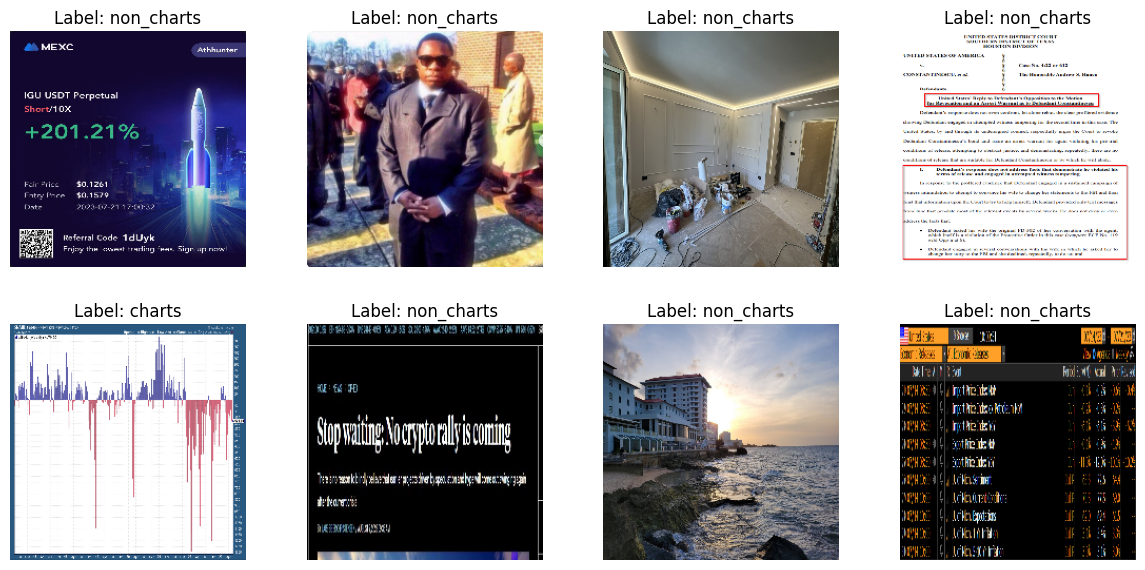

In [9]:
def plot_image_grid(images, labels, class_names, rows=2, cols=4):
    """
    Plot a tight grid of randomly selected images with their labels.

    Args:
        images (numpy.ndarray): Batch of images to display.
        labels (numpy.ndarray): Corresponding labels.
        class_names (list): Class names for labels.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    # Shuffle the indices
    indices = np.random.permutation(len(images))
    selected_images = images[indices[: rows * cols]]
    selected_labels = labels[indices[: rows * cols]]

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.tight_layout(pad=1.0)

    for i, ax in enumerate(axes.flat):
        if i >= len(selected_images):
            break
        ax.imshow(selected_images[i].astype("uint8"))
        ax.set_title(f"Label: {class_names[selected_labels[i]]}")
        ax.axis("off")

    plt.show()


# Convert tensors to numpy arrays for visualization
image_batch_np = image_batch.numpy()
label_batch_np = label_batch.numpy()

# Class names for labels
class_names = ["charts", "non_charts"]

# Plot the grid
plot_image_grid(image_batch_np, label_batch_np, class_names, rows=2, cols=4)

In [10]:
print(image_batch[0].numpy())

[[[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [242.      246.      255.     ]
  [242.      246.      255.     ]
  [242.      246.      255.     ]]

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [242.      246.      255.     ]
  [242.      246.      255.     ]
  [241.29465 245.29465 254.29465]]

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [242.      246.      255.     ]
  [242.      246.      255.     ]
  [243.      247.      255.     ]]

 ...

 [[ 49.      106.      213.     ]
  [ 49.      106.      213.     ]
  [ 49.      106.      213.     ]
  ...
  [ 49.      106.      213.     ]
  [ 49.      106.      213.     ]
  [ 49.      106.      213.     ]]

 [[ 49.      106.      213.     ]
  [ 49.      106.      213.     ]
  [ 49.      106.      213.     ]
  ...
  [ 49.      106.      213.     ]
  [ 

In [11]:
print(label_batch.numpy())

[1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1]


In [12]:
# Check the range of values
print(f"max value: {np.max(image_batch[0].numpy())}")
print(f"min value: {np.min(image_batch[0].numpy())}")

max value: 255.0
min value: 0.0


In [13]:
rescale_layer = tf.keras.layers.Rescaling(scale=1.0 / 255)

In [14]:
image_scaled = rescale_layer(image_batch[20]).numpy()

print(image_scaled)

[[[0.02944678 0.05689776 0.09611345]
  [0.03151511 0.05896609 0.09818178]
  [0.02566902 0.05312    0.09233569]
  ...
  [0.17600131 0.20388012 0.3176056 ]
  [0.12612687 0.1566752  0.27493694]
  [0.1117297  0.15101542 0.27058825]]

 [[0.03170393 0.05915491 0.0983706 ]
  [0.02559524 0.05304622 0.09226192]
  [0.02745098 0.05490196 0.09411766]
  ...
  [0.1365891  0.18674192 0.29841277]
  [0.11702538 0.17399317 0.29185033]
  [0.12156864 0.182458   0.3081583 ]]

 [[0.03283939 0.06029037 0.09950607]
  [0.02729842 0.0547494  0.0939651 ]
  [0.03369973 0.06115071 0.10036641]
  ...
  [0.10588236 0.17254902 0.2901961 ]
  [0.10847232 0.1810691  0.30464628]
  [0.11158964 0.18823531 0.31586134]]

 ...

 [[0.33256692 0.4366637  0.6245486 ]
  [0.34282374 0.44527328 0.6264593 ]
  [0.35157874 0.44569638 0.6218166 ]
  ...
  [0.18340634 0.28680226 0.44580102]
  [0.21366613 0.31706208 0.4760608 ]
  [0.2295244  0.33292034 0.4919191 ]]

 [[0.33965218 0.4494561  0.6376914 ]
  [0.34911847 0.4531801  0.6411353 ]


In [15]:
print(f"max value: {np.max(image_scaled)}")
print(f"min value: {np.min(image_scaled)}")

max value: 1.0
min value: 0.0


In [16]:
def normalize_dataset(dataset):
    """
    Normalize a tf.data.Dataset using a Rescaling layer.
    Args:
        dataset: The tf.data.Dataset to normalize.
    Returns:
        A normalized tf.data.Dataset.
    """
    return dataset.map(
        lambda image, label: (rescale_layer(image), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    ).prefetch(tf.data.AUTOTUNE)


# Normalize datasets
train_dataset_scaled = normalize_dataset(train_dataset)
val_dataset_scaled = normalize_dataset(val_dataset)
test_dataset_scaled = normalize_dataset(test_dataset)

In [17]:
# Get one batch of data
sample_batch = list(train_dataset_scaled.take(1))[0]

# Get the image
image_scaled = sample_batch[0][10].numpy()

# Check the range of values for this image
print(f"max value: {np.max(image_scaled)}")
print(f"min value: {np.min(image_scaled)}")

max value: 1.0
min value: 0.002393441740423441


2025-01-08 11:00:47.223132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
# model, model_file_name = create_model("mobile")
# model, model_file_name = create_model("custom-1")
# model, model_file_name = create_model("resnet")
# model, model_file_name = create_model("efficientnet")
# model, model_file_name = create_model("densenet")
model, model_file_name = create_model("mobile_large")

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,119,489 (11.90 MB)

 Trainable params: 123,137 (481.00 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [19]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (
    train_dataset_scaled.cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

# Configure the validation dataset
validation_dataset_final = val_dataset_scaled.cache().prefetch(
    PREFETCH_BUFFER_SIZE
)

# Configure the test dataset
test_dataset_final = test_dataset_scaled.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [20]:
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

In [21]:
history = model.fit(
    train_dataset_final,
    validation_data=validation_dataset_final,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True), save_checkpoint],
    verbose=1,
)

Epoch 1/20


2025-01-08 11:01:03.828347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 156 of 1000
2025-01-08 11:01:09.806261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    301/Unknown 226s 678ms/step - accuracy: 0.6696 - auc: 0.5984 - loss: 0.6713

2025-01-08 11:04:34.210235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/Jimmy/websharp/projects/python/ai/frostfire_chart_detect/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.55859, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:05:02.821114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 255s 775ms/step - accuracy: 0.6696 - auc: 0.5986 - loss: 0.6711 - val_accuracy: 0.7022 - val_auc: 0.8352 - val_loss: 0.5586
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.7472 - auc: 0.7358 - loss: 0.5410

2025-01-08 11:08:40.431439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 0.55859 to 0.48820, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:09:26.353645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 263s 876ms/step - accuracy: 0.7472 - auc: 0.7358 - loss: 0.5410 - val_accuracy: 0.7336 - val_auc: 0.8617 - val_loss: 0.4882
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7646 - auc: 0.7698 - loss: 0.5237

2025-01-08 11:12:59.732324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 3: val_loss improved from 0.48820 to 0.43753, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:13:41.916024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 256s 850ms/step - accuracy: 0.7646 - auc: 0.7699 - loss: 0.5237 - val_accuracy: 0.8067 - val_auc: 0.8812 - val_loss: 0.4375
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8082 - auc: 0.8181 - loss: 0.4760

2025-01-08 11:19:36.958434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 0.43753 to 0.40945, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:20:16.099845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8082 - auc: 0.8181 - loss: 0.4760 - val_accuracy: 0.8278 - val_auc: 0.9156 - val_loss: 0.4094
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8135 - auc: 0.8372 - loss: 0.4598

2025-01-08 11:23:37.364747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 5: val_loss improved from 0.40945 to 0.39681, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:24:22.953096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 247s 821ms/step - accuracy: 0.8134 - auc: 0.8372 - loss: 0.4598 - val_accuracy: 0.8229 - val_auc: 0.9195 - val_loss: 0.3968
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.7800 - auc: 0.8251 - loss: 0.4496

2025-01-08 11:27:52.542727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss improved from 0.39681 to 0.36796, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:28:34.883796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 252s 838ms/step - accuracy: 0.7800 - auc: 0.8251 - loss: 0.4496 - val_accuracy: 0.8400 - val_auc: 0.9389 - val_loss: 0.3680
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7876 - auc: 0.8478 - loss: 0.4369

2025-01-08 11:31:54.603070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 7: val_loss did not improve from 0.36796
301/301 ━━━━━━━━━━━━━━━━━━━━ 241s 801ms/step - accuracy: 0.7876 - auc: 0.8479 - loss: 0.4369 - val_accuracy: 0.8072 - val_auc: 0.9446 - val_loss: 0.4002
Epoch 8/20


2025-01-08 11:32:36.358332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.8055 - auc: 0.8718 - loss: 0.4056

2025-01-08 11:35:58.332802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss did not improve from 0.36796
301/301 ━━━━━━━━━━━━━━━━━━━━ 244s 812ms/step - accuracy: 0.8055 - auc: 0.8718 - loss: 0.4056 - val_accuracy: 0.8572 - val_auc: 0.9453 - val_loss: 0.3759
Epoch 9/20


2025-01-08 11:36:40.683739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8108 - auc: 0.8851 - loss: 0.3967

2025-01-08 11:40:13.142433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 9: val_loss improved from 0.36796 to 0.28310, saving model to ../models/mobilenetv3large_classifier.keras


2025-01-08 11:40:57.224537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 257s 854ms/step - accuracy: 0.8108 - auc: 0.8851 - loss: 0.3967 - val_accuracy: 0.8867 - val_auc: 0.9527 - val_loss: 0.2831
Epoch 10/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.8033 - auc: 0.8897 - loss: 0.3790

2025-01-08 11:44:23.807067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss did not improve from 0.28310
301/301 ━━━━━━━━━━━━━━━━━━━━ 249s 828ms/step - accuracy: 0.8033 - auc: 0.8897 - loss: 0.3791 - val_accuracy: 0.8700 - val_auc: 0.9536 - val_loss: 0.2999
Epoch 11/20


2025-01-08 11:45:06.454552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8268 - auc: 0.8891 - loss: 0.3780

2025-01-08 11:48:31.897285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 11: val_loss did not improve from 0.28310
301/301 ━━━━━━━━━━━━━━━━━━━━ 250s 832ms/step - accuracy: 0.8268 - auc: 0.8891 - loss: 0.3780 - val_accuracy: 0.8832 - val_auc: 0.9550 - val_loss: 0.2891
Epoch 12/20


2025-01-08 11:49:16.815090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8264 - auc: 0.8870 - loss: 0.3868

2025-01-08 11:52:38.513551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_loss did not improve from 0.28310
301/301 ━━━━━━━━━━━━━━━━━━━━ 240s 797ms/step - accuracy: 0.8264 - auc: 0.8870 - loss: 0.3868 - val_accuracy: 0.8989 - val_auc: 0.9568 - val_loss: 0.2853


2025-01-08 11:53:16.964239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [22]:
# Save the model --  See save_checkpoint
# model.save(model_file_name)

# model.export("../models/mobilenetv3_classifier_serving")

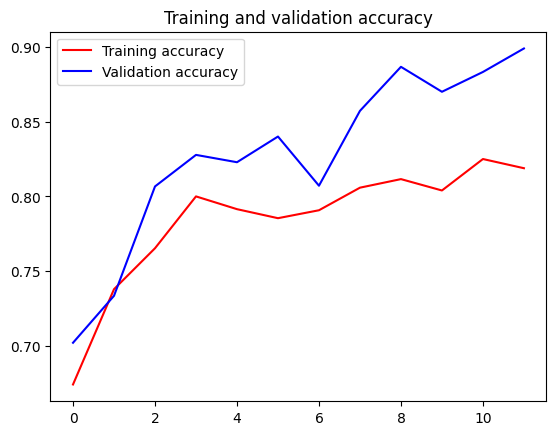

In [23]:
# Plot the training and validation accuracies for each epoch

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.show()

In [24]:
test_loss, test_accuracy, test_auc = model.evaluate(test_dataset_final)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 509ms/step - accuracy: 0.8745 - auc: 0.9476 - loss: 0.3065
Test Loss: 0.29654428362846375
Test Accuracy: 0.8808212280273438
Test AUC: 0.9414394497871399


2025-01-08 11:53:51.820559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [25]:


# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)


def file_predict(filename, file, out):
    """A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=IMG_SIZE)
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction <= 0.5:
            print(filename + " is a chart")
        else:
            print(filename + " is not a chart")


def on_upload_change(change):
    """A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)

    items = change.new
    for item in items:  # Loop if there is more than one file uploaded
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names="value")

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [26]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

# from IPython import get_ipython

# k = get_ipython().kernel

# k.do_shutdown(restart=False)